In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw 

import hypergraphx as hgx
from hypergraphx.filters import metadata_filters

from tqdm.notebook import tqdm

from tqdm.auto import tqdm
tqdm.pandas()

import sys
sys.path += ['../']

from src.plot_configs import w_inc_fullpage, h_inc, set_plot_configs
set_plot_configs()

from src.filters import get_svmis

FIG_FOLD = "../paper/figures/"
if not os.path.exists(FIG_FOLD):
    os.makedirs(FIG_FOLD)


In [2]:
def filter_by_cuisine(H, cuisine):

    H_filtered = H.copy()

    for edge, meta in H.get_edges(metadata=True).items():
        cuisines = meta["cuisine"].split(" - ")
        if cuisine not in cuisines:
            H_filtered.remove_edge(edge)

    # remove isolated nodes
    for node in H_filtered.isolated_nodes():
        H_filtered.remove_node(node)

    return H_filtered

In [3]:
def load_recipies():

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()
    all_cuisines_list = [c for c in all_cuisines_list if c not in CUISINES_EXCLUDE]

    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        if cuisine in CUISINES_EXCLUDE:
            continue

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]
            category = row["category"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                H.add_node(node_id, metadata={"name": ingredient, "category": category})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            #edge_meta["title"] += f" - {r_meta['title']}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list

In [4]:
# load the dataset
H, ingredients_df, all_cuisines_list = load_recipies()
H.num_nodes(), H.num_edges()

(604, 43751)

In [5]:
ingredients_df.head()

,ingredient,category,node_id
0,capsicum,Vegetable,0
1,chili pepper,Vegetable,1
2,sunflower,Flower,2
3,buttermilk,Dairy,3
4,cumin,Spice,4


In [6]:
all_cuisines_list

['indian',
 'african',
 'chinese',
 'thai',
 'south_east_asia',
 'middle_east',
 'korean',
 'japanese',
 'australasian',
 'mexican',
 'caribbean',
 'south_american',
 'central_european',
 'greek',
 'french',
 'misc_portuguese',
 'italian',
 'british_isles',
 'scandinavian',
 'east_european',
 'spanish',
 'american',
 'canadian']

In [7]:
# remove hyperedges of size > 10
H_cut = H.copy()

for size in range(11, H_cut.max_size() + 1):
    for edge in H_cut.get_edges(size=size):
        H_cut.remove_edge(edge)

# remove isolated nodes
for node in H_cut.isolated_nodes():
    H_cut.remove_node(node)

print("Number of nodes after cutting: ", H_cut.num_nodes())
print("Number of hyperedges after cutting: ", H_cut.num_edges())
print("Number of recipes after cutting: ", sum(H_cut.get_weights()))

Number of nodes after cutting:  580
Number of hyperedges after cutting:  32291
Number of recipes after cutting:  32291


In [8]:
# extract SVMIS
svmis_file = "../results/recipes/svmis_recipes.parquet"

if not os.path.exists(svmis_file):
    print("Extracting SVMIS...")
    svmis_df = get_svmis(H_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_df = pd.concat(svmis_df).reset_index(drop=True)

    # save file
    if not os.path.exists(os.path.dirname(svmis_file)):
        os.makedirs(os.path.dirname(svmis_file))
    svmis_df.to_parquet(svmis_file)

else:
    print("Loading SVMIS from file...")
    svmis_df = pd.read_parquet(svmis_file)

svmis_df.head()

Loading SVMIS from file...


,group,pvalue,fdr,size
0,"[2, 3, 4, 5, 7, 8, 10, 11, 13, 27]",3.847664e-14,False,10
1,"[1, 3, 4, 5, 7, 8, 13, 27, 42, 43]",3.654129e-12,False,10
2,"[2, 3, 5, 7, 11, 13, 15, 18, 35, 38]",1.569218e-12,False,10
3,"[2, 4, 7, 9, 18, 19, 31, 38, 50, 63]",1.256009e-12,False,10
4,"[2, 3, 6, 11, 13, 15, 16, 31, 37, 49]",4.246454e-15,False,10


In [9]:
# get size of sets
svmis_df.loc[:, "size"] = svmis_df["group"].apply(len)

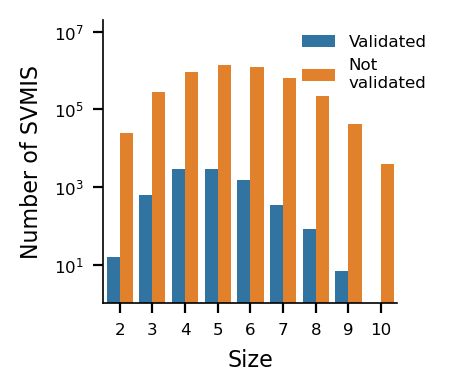

In [10]:
# plot number of validated and non-validated sets
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3, h_inc))

# plot counts of svmis by size
sns.countplot(data=svmis_df, x="size", hue="fdr", hue_order=[True, False], ax=ax)

ax.set_yscale("log")
ax.set_ylim(1, 2e7)
ax.set_yticks([1e1, 1e3, 1e5, 1e7])

# remove minor thicks from y axis
ax.yaxis.set_minor_locator(plt.NullLocator())

ax.set_ylabel("Number of SVMIS")
ax.set_xlabel("Size")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Validated", "Not\nvalidated"], loc="upper right", bbox_to_anchor=(1.15, 1.), title=None, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### Frequency-rank analysis of ingredients and validated sets across recipes

In [12]:
# get frequency of all ingredients in the hypergraph
freq_ingredients = np.array(sorted(list(H_cut.degree_sequence().values()), reverse=True))

In [13]:
# get frequency of all validated sets
all_recipes = set(H_cut.get_edges())

freq_svmis_df = []
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)
    group_ingredients = " - ".join([H_cut.get_node_metadata(n)["name"] for n in group])

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r).issuperset(group)}
    cuisines_ = [f for r in recipes_ for f in H_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

    line = {
        "group": group,
        "group_ingredients": group_ingredients,
        "size": len(group),
        "n_recipes": len(recipes_),
        "cuisine_list": cuisines_
    }

    freq_svmis_df.append(line)

freq_svmis_df = pd.DataFrame(freq_svmis_df)
freq_svmis_df.head()

  0%|          | 0/8297 [00:00<?, ?it/s]

,group,group_ingredients,size,n_recipes,cuisine_list
0,"{1, 39, 40, 15, 47, 17, 18, 58, 31}",chili pepper - rice - ghee - cardamom - ginger...,9,2,"[indian, indian]"
1,"{2, 7, 10, 11, 44, 13, 23, 56, 26}",sunflower - mustard oil - asafoetida - cayenne...,9,2,"[indian, indian]"
2,"{4, 8, 40, 10, 11, 15, 17, 18, 51}",cumin - nigella seed - ghee - asafoetida - cay...,9,2,"[indian, indian]"
3,"{1, 2, 3, 7, 10, 12, 13, 23, 26}",chili pepper - sunflower - buttermilk - mustar...,9,2,"[indian, indian]"
4,"{1, 2, 3, 4, 40, 10, 45, 26, 29}",chili pepper - sunflower - buttermilk - cumin ...,9,2,"[indian, indian]"


##### Frequency of validated sets in randomized model

In [11]:
def randomize_bip_conf_model(recipes_df, seed=None):
    """ Ensuring node labels are the same
    """
    import networkx as nx

    # make the graph
    G = nx.Graph()

    ing_nodes = recipes_df["ingredient"].unique().tolist()
    rec_nodes = recipes_df["id"].unique().tolist()

    G.add_nodes_from(ing_nodes, bipartite=0)
    G.add_nodes_from(rec_nodes, bipartite=1)

    G.add_edges_from(recipes_df[["id", "ingredient"]].values.tolist())

    # get degree sequences of ingredients and recipes
    ing_deg_seq = [G.degree(ing) for ing in ing_nodes]
    rec_deg_seq = [G.degree(rec) for rec in rec_nodes]


    # build configuration model with explicit node lists
    G_tmp = nx.bipartite.configuration_model(rec_deg_seq, ing_deg_seq, create_using=nx.Graph(), seed=seed)

    # relabel nodes to maintain the original labels
    left_map  = dict(zip(range(len(rec_nodes)), rec_nodes))
    right_map = dict(zip(range(len(rec_nodes), len(rec_nodes)+len(ing_nodes)), ing_nodes))

    mapping = {**left_map, **right_map}
    G_tmp = nx.relabel_nodes(G_tmp, mapping)

    # return to dataframe
    recipes_rand_df = []
    for rec_id in rec_nodes:
        for ing in G_tmp.neighbors(rec_id):
            recipes_rand_df.append([rec_id, ing])

    recipes_rand_df = pd.DataFrame(recipes_rand_df, columns=["id", "ingredient"])
    recipes_rand_df = recipes_rand_df.merge(recipes_df[["id", "cuisine"]].drop_duplicates(), on="id", how="left")

    return recipes_rand_df


def load_recipies_shuff(seed=None):

    if seed is None:
        seed = 42

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")
    recipes_df = recipes_df[~recipes_df.cuisine.isin(CUISINES_EXCLUDE)]

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()

    # shuffle in like a bipartite configuration model for each cuisine
    recipes_shuff_df = []
    for iii, cuisine in enumerate(all_cuisines_list):
        df_ = recipes_df[recipes_df["cuisine"] == cuisine]
        df_shuff = randomize_bip_conf_model(df_, seed=seed + iii * 123)
        recipes_shuff_df.append(df_shuff)

    recipes_df = pd.concat(recipes_shuff_df).reset_index(drop=True)
        
    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                H.add_node(node_id, metadata={"name": ingredient})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list


def get_freq_rank_plot_shuff(seed=None):

    H_shuff, _, _ = load_recipies_shuff(seed=seed)

    # remove hyperedges of size > 10
    H_shuff_cut = H_shuff.copy()

    for size in range(11, H_shuff_cut.max_size() + 1):
        for edge in H_shuff_cut.get_edges(size=size):
            H_shuff_cut.remove_edge(edge)

    # remove isolated nodes
    for node in H_shuff_cut.isolated_nodes():
        H_shuff_cut.remove_node(node)

    # run SVMIS extraction
    svmis_shuff_df = get_svmis(H_shuff_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_shuff_df = pd.concat(svmis_shuff_df).reset_index(drop=True)

    # count support of validated sets in recipes
    all_recipes_shuff = set(H_shuff_cut.get_edges())

    freq_svmis_shuff_df = []
    for _, row in tqdm(svmis_shuff_df.query("fdr == True").iterrows(), total=svmis_shuff_df.fdr.sum(), leave=False):
        
        # the the validated set
        group = row["group"]
        group = set(group)

        # get all recipes that contain this group and the set of cuisines those recipes belong to
        recipes_ = {r for r in all_recipes_shuff if set(r).issuperset(group)}
        cuisines_ = [f for r in recipes_ for f in H_shuff_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

        line = {
            "group": group,
            "size": len(group),
            "n_recipes": len(recipes_),
            "cuisine_list": cuisines_
        }

        freq_svmis_shuff_df.append(line)

    freq_svmis_shuff_df = pd.DataFrame(freq_svmis_shuff_df)

    return freq_svmis_shuff_df

In [15]:
import pickle

NITERS = 50
RNG = np.random.RandomState(42)
file_null_freqs = "../results/recipes/svmis_counts_nulls.pkl"

if not os.path.exists(file_null_freqs):
    print("Computing null frequencies..")

    freq_svmis_nulls_list = []
    for _ in tqdm(range(NITERS), total=NITERS):
        seed = RNG.randint(0, 10000)
        freq_svmis_shuff_df = get_freq_rank_plot_shuff(seed=seed)
        freq_svmis_nulls_list.append(freq_svmis_shuff_df.n_recipes.sort_values(ascending=False).values)

    import pickle
    with open(file_null_freqs, "wb") as ww:
        pickle.dump(freq_svmis_nulls_list, ww)

else:
    print("Load precomputed..")
    with open(file_null_freqs, "rb") as rr:
        freq_svmis_nulls_list = pickle.load(rr)

Load precomputed..


##### Plot the distributions

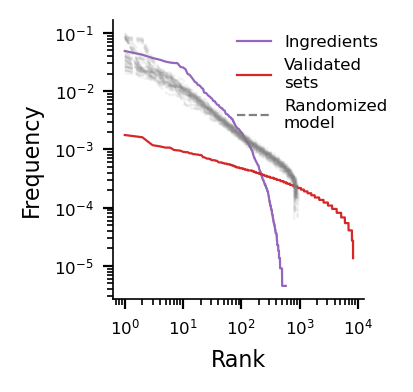

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3, h_inc))

# plot freq-rank of ingredients
ax.plot(np.arange(1, len(freq_ingredients) + 1), freq_ingredients/freq_ingredients.sum(), linestyle='-', label="Ingredients", color='C4')

# plot freq-rank of validated sets
freq_validated_sets = freq_svmis_df.sort_values("n_recipes", ascending=False)["n_recipes"].values
ax.plot(np.arange(1, len(freq_validated_sets) + 1), freq_validated_sets/freq_validated_sets.sum(), linestyle='-', label="Validated sets", color='C3')

# plot envelope of null model
for freq_null in freq_svmis_nulls_list:
    ax.plot(np.arange(1, len(freq_null) + 1), freq_null/freq_null.sum(), color='grey', alpha=0.1, linestyle='--')

ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

# make legend manyally
handles = [
    plt.Line2D([0], [0], color='C4', linestyle='-', label='Ingredients'),
    plt.Line2D([0], [0], color='C3', linestyle='-', label='Validated\nsets'),
    plt.Line2D([0], [0], color='grey', linestyle='--', label='Randomized\nmodel')
]
ax.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.15, 1.), frameon=False)


ax.set_xscale("log")
ax.set_yscale("log")

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_aspect('equal', adjustable='box')
fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_FreqRank.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

##### Frequency-rank of ingredients

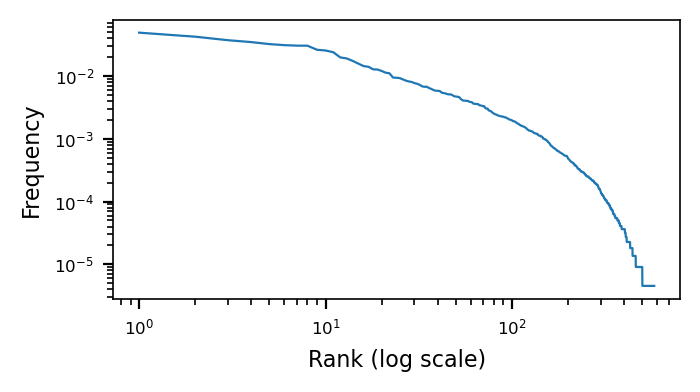

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

ys = np.array(sorted(list(H_cut.degree_sequence().values()), reverse=True))
xs = np.arange(1, len(ys) + 1)

ax.plot(xs, ys / ys.sum(), marker='', linestyle='-')

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Rank (log scale)")
ax.set_ylabel("Frequency")

fig.tight_layout()

In [102]:
ranks0 = xs
freqs0 = ys
data0 = np.repeat(ranks0, freqs0)

<Axes: >

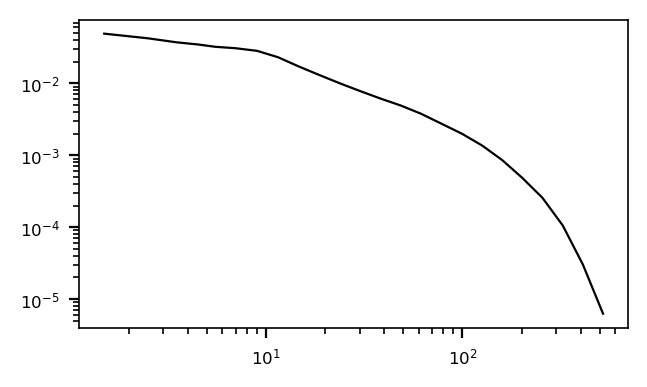

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data0, color='k', ax=ax)

In [113]:
# let's see in detail what happens when varying xmin
xmins = np.arange(1, data0.max(), 1)

res0_df = []
for xmin in tqdm(xmins, total=len(xmins), leave=False):
    data_fit_ = powerlaw.Fit(data0, discrete=True, xmin=xmin)

    line = {
        "xmin": xmin,
        "alpha": data_fit_.power_law.alpha,
        "sigma": data_fit_.power_law.sigma,
        "D": data_fit_.power_law.D
    }
    line["sigma_over_alpha"] = line["sigma"] / line["alpha"]
    res0_df.append(line)

res0_df = pd.DataFrame(res0_df)
res0_df.head()

  0%|          | 0/579 [00:00<?, ?it/s]

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,
/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


,xmin,alpha,sigma,D,sigma_over_alpha
0,1,1.285348,0.000608,0.281062,0.000473
1,2,1.370977,0.000811,0.228285,0.000592
2,3,1.431850,0.000966,0.193362,0.000675
3,4,1.481709,0.001100,0.168322,0.000742
4,5,1.524164,0.001222,0.151930,0.000802


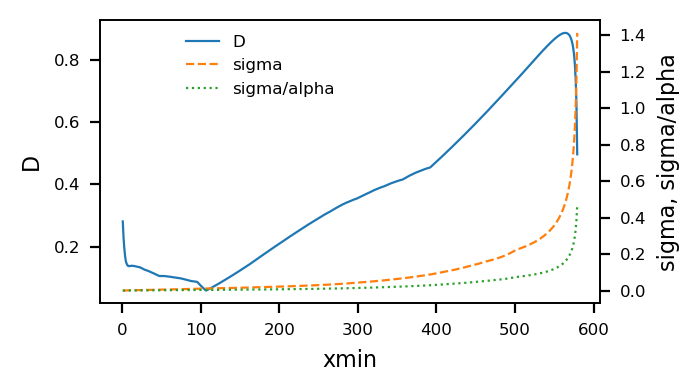

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

sns.lineplot(data=res0_df.fillna("no"), x="xmin", y="D", ax=ax)

ax_tw = ax.twinx()
sns.lineplot(data=res0_df.fillna("no"), x="xmin", y="sigma", linestyle="--", color="C1", ax=ax_tw, legend=True)
sns.lineplot(data=res0_df.fillna("no"), x="xmin", y="sigma_over_alpha", linestyle=":", color="C2", ax=ax_tw, legend=False)
ax_tw.set_ylabel("sigma, sigma/alpha")

# set legend manually
handles = [
    plt.Line2D([0], [0], color='C0', linestyle='-'),
    plt.Line2D([0], [0], color='C1', linestyle='--'),
    plt.Line2D([0], [0], color='C2', linestyle=':'),
]
labels = ["D", "sigma", "sigma/alpha"]
ax.legend(handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(.5, 1.), title=None, frameon=False)

fig.tight_layout()

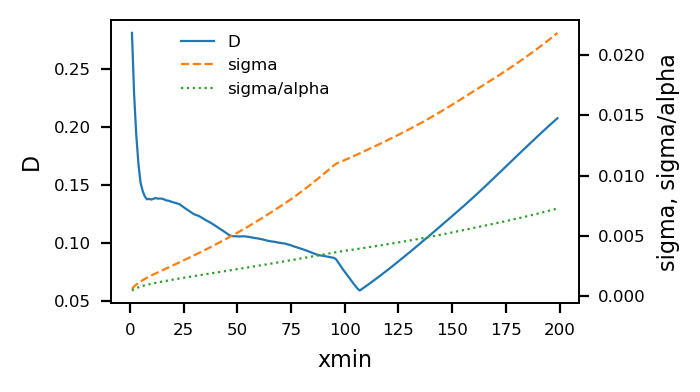

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

sns.lineplot(data=res0_df.fillna("no").query("xmin < 200"), x="xmin", y="D", ax=ax)

ax_tw = ax.twinx()
sns.lineplot(data=res0_df.fillna("no").query("xmin < 200"), x="xmin", y="sigma", linestyle="--", color="C1", ax=ax_tw, legend=True)
sns.lineplot(data=res0_df.fillna("no").query("xmin < 200"), x="xmin", y="sigma_over_alpha", linestyle=":", color="C2", ax=ax_tw, legend=False)
ax_tw.set_ylabel("sigma, sigma/alpha")

# set legend manually
handles = [
    plt.Line2D([0], [0], color='C0', linestyle='-'),
    plt.Line2D([0], [0], color='C1', linestyle='--'),
    plt.Line2D([0], [0], color='C2', linestyle=':'),
]
labels = ["D", "sigma", "sigma/alpha"]
ax.legend(handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(.5, 1.), title=None, frameon=False)


fig.tight_layout()

There is a flattening of D at xmin=7.

In [106]:
data0_fit = powerlaw.Fit(data0, discrete=True, xmin=7, xmax=None)

In [107]:
plaw0 = data0_fit.power_law
trunc_plaw0 = data0_fit.truncated_power_law
lognorm0 = data0_fit.lognormal
pos_lognorm0 = data0_fit.lognormal_positive
exponential0 = data0_fit.exponential

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


In [108]:
# the truncated powerlaw is strongly favored
data0_fit.distribution_compare("power_law", "truncated_power_law")

(np.float64(-31085.649725819723), np.float64(0.0))

In [109]:
# the truncated powerlaw is strongly favored
data0_fit.distribution_compare("truncated_power_law", "lognormal")

(np.float64(3907.5412331999437), np.float64(0.0))

In [110]:
data0_fit.distribution_compare("truncated_power_law", "exponential")

(np.float64(11040.414262453562), np.float64(0.0))

In [ ]:
# slope and cutoff -- powerlaw barely for one order of magnitude
trunc_plaw0.alpha, trunc_plaw0.Lambda ** -1

(np.float64(0.7381051292447934), np.float64(110.50934119581426))

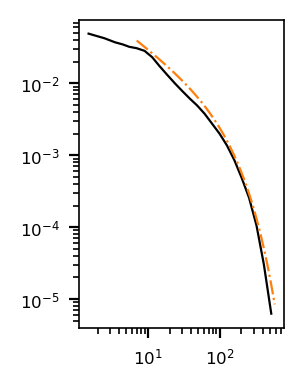

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data0, color='k', ax=ax)

trunc_plaw0.plot_pdf(color='C1', linestyle='-.', ax=ax)

ax.set_aspect("equal", adjustable='box')

##### Frequency-rank of validated sets

In [13]:
# count support of validated sets in recipes
all_recipes = set(H_cut.get_edges())

freq_svmis_df = []
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)
    group_ingredients = " - ".join([H_cut.get_node_metadata(n)["name"] for n in group])

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r).issuperset(group)}
    cuisines_ = [f for r in recipes_ for f in H_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

    line = {
        "group": group,
        "group_ingredients": group_ingredients,
        "size": len(group),
        "n_recipes": len(recipes_),
        "cuisine_list": cuisines_
    }

    freq_svmis_df.append(line)

freq_svmis_df = pd.DataFrame(freq_svmis_df)
freq_svmis_df.head()

  0%|          | 0/8297 [00:00<?, ?it/s]

,group,group_ingredients,size,n_recipes,cuisine_list
0,"{1, 39, 40, 15, 47, 17, 18, 58, 31}",chili pepper - rice - ghee - cardamom - ginger...,9,2,"[indian, indian]"
1,"{2, 7, 10, 11, 44, 13, 23, 56, 26}",sunflower - mustard oil - asafoetida - cayenne...,9,2,"[indian, indian]"
2,"{4, 8, 40, 10, 11, 15, 17, 18, 51}",cumin - nigella seed - ghee - asafoetida - cay...,9,2,"[indian, indian]"
3,"{1, 2, 3, 7, 10, 12, 13, 23, 26}",chili pepper - sunflower - buttermilk - mustar...,9,2,"[indian, indian]"
4,"{1, 2, 3, 4, 40, 10, 45, 26, 29}",chili pepper - sunflower - buttermilk - cumin ...,9,2,"[indian, indian]"


In [14]:
ranks = np.arange(1, len(freq_svmis_df) + 1)
freqs = freq_svmis_df["n_recipes"].sort_values(ascending=False).values
data = np.repeat(ranks, freqs)

In [119]:
# let's see in detail what happens when varying xmin
xmins = np.arange(1, 1000, 1)

res_df = []
for xmin in tqdm(xmins, total=len(xmins), leave=False):
    data_fit_ = powerlaw.Fit(data, discrete=True, xmin=xmin)

    line = {
        "xmin": xmin,
        "alpha": data_fit_.power_law.alpha,
        "sigma": data_fit_.power_law.sigma,
        "D": data_fit_.power_law.D
    }
    line["sigma_over_alpha"] = line["sigma"] / line["alpha"]
    res_df.append(line)

res_df = pd.DataFrame(res_df)
res_df.head()


  0%|          | 0/999 [00:00<?, ?it/s]

,xmin,alpha,sigma,D,sigma_over_alpha
0,1,1.128922,0.000475,0.424987,0.000421
1,2,1.147347,0.000544,0.406000,0.000474
2,3,1.158680,0.000586,0.395392,0.000506
3,4,1.167334,0.000619,0.387810,0.000530
4,5,1.174421,0.000645,0.381855,0.000549


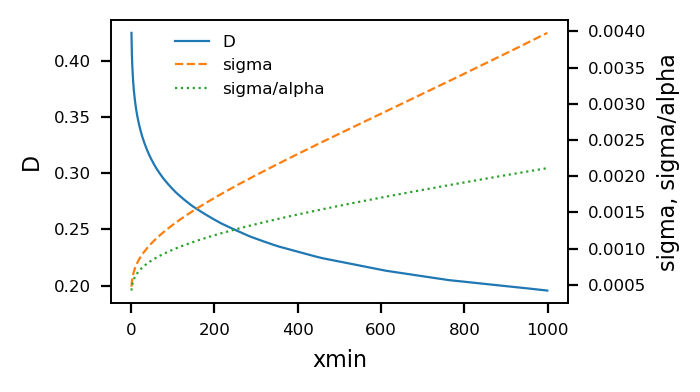

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

sns.lineplot(data=res_df.fillna("no"), x="xmin", y="D", ax=ax)

ax_tw = ax.twinx()
sns.lineplot(data=res_df.fillna("no"), x="xmin", y="sigma", linestyle="--", color="C1", ax=ax_tw, legend=True)
sns.lineplot(data=res_df.fillna("no"), x="xmin", y="sigma_over_alpha", linestyle=":", color="C2", ax=ax_tw, legend=False)

ax_tw.set_ylabel("sigma, sigma/alpha")

# set legend manually
handles = [
    plt.Line2D([0], [0], color='C0', linestyle='-'),
    plt.Line2D([0], [0], color='C1', linestyle='--'),
    plt.Line2D([0], [0], color='C2', linestyle=':'),
]
labels = ["D", "sigma", "sigma/alpha"]
ax.legend(handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(.5, 1.), title=None, frameon=False)

fig.tight_layout()

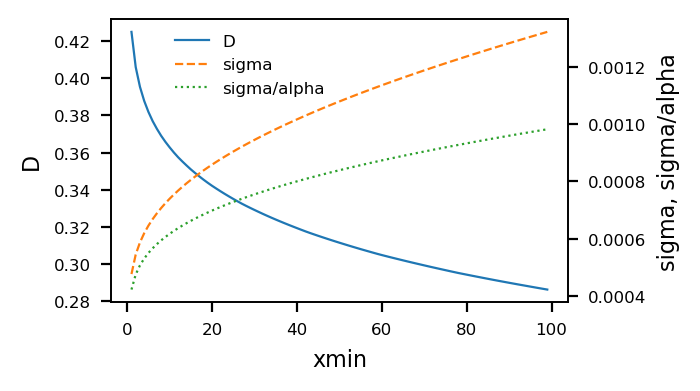

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

sns.lineplot(data=res_df.fillna("no").query("xmin < 100"), x="xmin", y="D", ax=ax)

ax_tw = ax.twinx()
sns.lineplot(data=res_df.fillna("no").query("xmin < 100"), x="xmin", y="sigma", linestyle="--", color="C1", ax=ax_tw, legend=True)
sns.lineplot(data=res_df.fillna("no").query("xmin < 100"), x="xmin", y="sigma_over_alpha", linestyle=":", color="C2", ax=ax_tw, legend=False)
ax_tw.set_ylabel("sigma, sigma/alpha")

# set legend manually
handles = [
    plt.Line2D([0], [0], color='C0', linestyle='-'),
    plt.Line2D([0], [0], color='C1', linestyle='--'),
    plt.Line2D([0], [0], color='C2', linestyle=':'),
]
labels = ["D", "sigma", "sigma/alpha"]
ax.legend(handles=handles, labels=labels, loc="upper right", bbox_to_anchor=(.5, 1.), title=None, frameon=False)

fig.tight_layout()

For what concerns xmin, we also need an xmin.

In [91]:
data_fit = powerlaw.Fit(data, discrete=True, xmin=3, xmax=5000)

In [92]:
plaw = data_fit.power_law
trunc_plaw = data_fit.truncated_power_law
lognorm = data_fit.lognormal
pos_lognorm = data_fit.lognormal_positive
exponential = data_fit.exponential

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')
/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution exponential; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


In [93]:
# the truncated powerlaw is strongly favored
data_fit.distribution_compare("power_law", "truncated_power_law")

(np.float64(-34552.13258226551), np.float64(0.0))

In [94]:
# the truncated powerlaw is strongly favored
data_fit.distribution_compare("truncated_power_law", "lognormal")

(np.float64(55.678503903778065), np.float64(1.1180471197389117e-05))

In [95]:
data_fit.distribution_compare("truncated_power_law", "exponential")

(np.float64(1311.0357075831766), np.float64(3.436694833050688e-125))

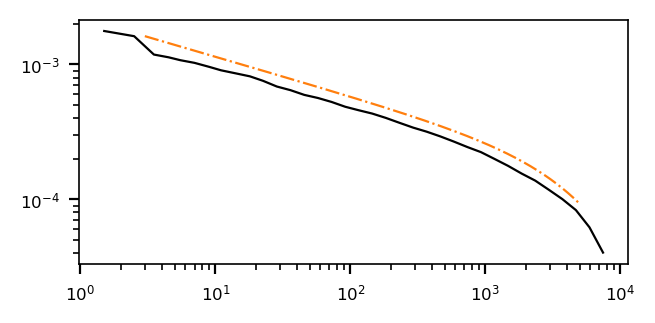

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data, color='k', ax=ax)

trunc_plaw.plot_pdf(color='C1', linestyle='-.', ax=ax)

ax.set_aspect("equal", adjustable='box')

##### Comparison with randomized system


In [ ]:
def randomize_bip_conf_model(recipes_df, seed=None):
    """ Ensuring node labels are the same
    """
    import networkx as nx

    # make the graph
    G = nx.Graph()

    ing_nodes = recipes_df["ingredient"].unique().tolist()
    rec_nodes = recipes_df["id"].unique().tolist()

    G.add_nodes_from(ing_nodes, bipartite=0)
    G.add_nodes_from(rec_nodes, bipartite=1)

    G.add_edges_from(recipes_df[["id", "ingredient"]].values.tolist())

    # get degree sequences of ingredients and recipes
    ing_deg_seq = [G.degree(ing) for ing in ing_nodes]
    rec_deg_seq = [G.degree(rec) for rec in rec_nodes]


    # build configuration model with explicit node lists
    G_tmp = nx.bipartite.configuration_model(rec_deg_seq, ing_deg_seq, create_using=nx.Graph(), seed=seed)

    # relabel nodes to maintain the original labels
    left_map  = dict(zip(range(len(rec_nodes)), rec_nodes))
    right_map = dict(zip(range(len(rec_nodes), len(rec_nodes)+len(ing_nodes)), ing_nodes))

    mapping = {**left_map, **right_map}
    G_tmp = nx.relabel_nodes(G_tmp, mapping)

    # return to dataframe
    recipes_rand_df = []
    for rec_id in rec_nodes:
        for ing in G_tmp.neighbors(rec_id):
            recipes_rand_df.append([rec_id, ing])

    recipes_rand_df = pd.DataFrame(recipes_rand_df, columns=["id", "ingredient"])
    recipes_rand_df = recipes_rand_df.merge(recipes_df[["id", "cuisine"]].drop_duplicates(), on="id", how="left")

    return recipes_rand_df


def load_recipies_shuff(seed=None):

    if seed is None:
        seed = 42

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")
    recipes_df = recipes_df[~recipes_df.cuisine.isin(CUISINES_EXCLUDE)]

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()

    # shuffle in like a bipartite configuration model for each cuisine
    recipes_shuff_df = []
    for iii, cuisine in enumerate(all_cuisines_list):
        df_ = recipes_df[recipes_df["cuisine"] == cuisine]
        df_shuff = randomize_bip_conf_model(df_, seed=seed + iii * 123)
        recipes_shuff_df.append(df_shuff)

    recipes_df = pd.concat(recipes_shuff_df).reset_index(drop=True)
        
    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                H.add_node(node_id, metadata={"name": ingredient})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list


def get_freq_rank_plot_shuff(seed=None):

    H_shuff, _, _ = load_recipies_shuff(seed=seed)

    # remove hyperedges of size > 10
    H_shuff_cut = H_shuff.copy()

    for size in range(11, H_shuff_cut.max_size() + 1):
        for edge in H_shuff_cut.get_edges(size=size):
            H_shuff_cut.remove_edge(edge)

    # remove isolated nodes
    for node in H_shuff_cut.isolated_nodes():
        H_shuff_cut.remove_node(node)

    # run SVMIS extraction
    svmis_shuff_df = get_svmis(H_shuff_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_shuff_df = pd.concat(svmis_shuff_df).reset_index(drop=True)

    # count support of validated sets in recipes
    all_recipes_shuff = set(H_shuff_cut.get_edges())

    freq_svmis_shuff_df = []
    for _, row in tqdm(svmis_shuff_df.query("fdr == True").iterrows(), total=svmis_shuff_df.fdr.sum(), leave=False):
        
        # the the validated set
        group = row["group"]
        group = set(group)

        # get all recipes that contain this group and the set of cuisines those recipes belong to
        recipes_ = {r for r in all_recipes_shuff if set(r).issuperset(group)}
        cuisines_ = [f for r in recipes_ for f in H_shuff_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

        line = {
            "group": group,
            "size": len(group),
            "n_recipes": len(recipes_),
            "cuisine_list": cuisines_
        }

        freq_svmis_shuff_df.append(line)

    freq_svmis_shuff_df = pd.DataFrame(freq_svmis_shuff_df)

    return freq_svmis_shuff_df

In [165]:
NITERS = 50
RNG = np.random.RandomState(42)
file_null_freqs = "../results/recipes/svmis_counts_nulls.pkl"

if not os.path.exists(file_null_freqs):
    print("Computing null frequencies..")

    freq_svmis_nulls_list = []
    for _ in tqdm(range(NITERS), total=NITERS):
        seed = RNG.randint(0, 10000)
        freq_svmis_shuff_df = get_freq_rank_plot_shuff(seed=seed)
        freq_svmis_nulls_list.append(freq_svmis_shuff_df.n_recipes.sort_values(ascending=False).values)

    import pickle
    with open(file_null_freqs, "wb") as ww:
        pickle.dump(freq_svmis_nulls_list, ww)

else:
    print("Load precomputed..")
    with open(file_null_freqs, "rb") as rr:
        freq_svmis_nulls_list = pickle.load(rr)

Computing null frequencies..


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/830 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/876 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/865 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/865 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/847 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/842 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/876 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/818 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/866 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/885 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/867 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/833 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/876 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

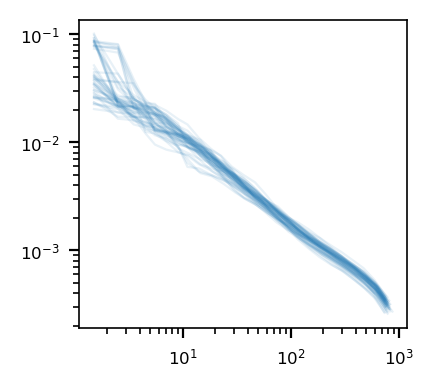

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

ddd = []
for freq_null in freq_svmis_nulls_list:

    freq_null = np.array(sorted(freq_null, reverse=True))
    rank_null = np.arange(1, len(freq_null) + 1)
    data_null = np.repeat(rank_null, freq_null)
    ddd.append(data_null)

    powerlaw.plot_pdf(data_null, color='C0', alpha=0.1, ax=ax)

ax.set_aspect("equal", adjustable='box')


In [237]:
fff = powerlaw.Fit(data_null, discrete=True, xmin=20, xmax=600)

In [203]:
fff.distribution_compare("power_law", "truncated_power_law")

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


(np.float64(-27778.88680345436), np.float64(0.0))

In [238]:
pppp_pl = fff.power_law
tttt_pl = fff.truncated_power_law

KeyboardInterrupt: 

In [239]:
pppp_pl.alpha

np.float64(1.0000000539021414)

In [241]:
import numpy as np
from scipy.optimize import minimize

def neg_log_likelihood(alpha, data, xmin, xmax):
    # discrete truncated power law
    xs = np.arange(xmin, xmax+1)
    Z = np.sum(xs**(-alpha))
    return -np.sum(-alpha * np.log(data) - np.log(Z))

xmin = min(data_null)
xmax = max(data_null)  # can be very large if no upper cutoff
res = minimize(neg_log_likelihood, x0=1.5, args=(data_null, xmin, xmax), bounds=[(0.01, None)])
print(res.x[0])

0.793224943284394


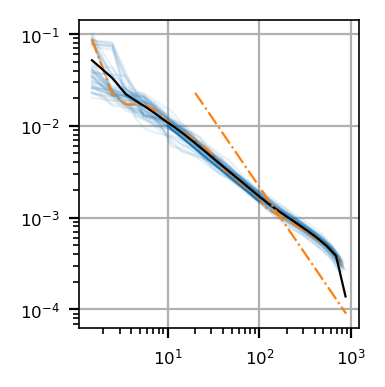

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

for freq_null in freq_svmis_nulls_list:

    freq_null = np.array(sorted(freq_null, reverse=True))
    rank_null = np.arange(1, len(freq_null) + 1)
    data_null = np.repeat(rank_null, freq_null)

    powerlaw.plot_pdf(data_null, color='C0', alpha=0.1, ax=ax)

fff.plot_pdf(original_data=True, color='C1', linestyle='-.', ax=ax)
powerlaw.plot_pdf(np.concatenate(ddd), color='k', ax=ax)

fff.power_law.plot_pdf(color='C1', linestyle='-.', ax=ax)

ax.grid()

ax.plot([10, 100], [1e-2, 1.5e-3])

ax.set_aspect("equal", adjustable='box')


In [ ]:
[10, 100], [1e-2, 1.5e-3]

In [223]:
np.arctan((-2 - np.log10(1.5e-3)) / (2 - 1))

np.float64(0.6891503794076017)

In [158]:
data_fk_fit.power_law.alpha

np.float64(1.000000050775161)

In [160]:
data_fk_fit.truncated_power_law.alpha

np.float64(0.6517778453767207)

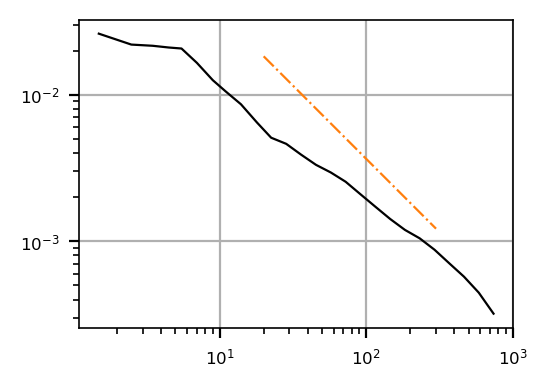

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data_fk, color='k', ax=ax)

data_fk_fit.power_law.plot_pdf(color='C1', linestyle='-.', ax=ax)

ax.set_aspect("equal", adjustable='box')

ax.grid()

#### Put all together

In [251]:
def envelop_distribs(data_list):

    import numpy as np

    # Suppose all your realizations are in a list: data_list = [X1, X2, ..., XN]
    xmin = min(np.min(X) for X in data_list)
    xmax = max(np.max(X) for X in data_list)
    xgrid = np.linspace(xmin, xmax, 200)  # 200 bins, adjust as needed

    from scipy.stats import gaussian_kde

    pdfs = []

    for X in data_list:
        kde = gaussian_kde(X)
        pdf = kde(xgrid)  # evaluate KDE on common grid
        pdfs.append(pdf)

    pdfs = np.array(pdfs)  # shape: (N, len(xgrid))

    pdfs = []

    for X in data_list:
        hist, _ = np.histogram(X, bins=xgrid, density=True)
        pdfs.append(hist)

    pdfs = np.array(pdfs)

    x_percent = 95
    lower_percentile = (100 - x_percent) / 2
    upper_percentile = 100 - lower_percentile

    lower_envelope = np.percentile(pdfs, lower_percentile, axis=0)
    upper_envelope = np.percentile(pdfs, upper_percentile, axis=0)
    median_pdf = np.median(pdfs, axis=0)  # optional, for plotting the median

    return xgrid, lower_envelope, upper_envelope, median_pdf

In [ ]:
xgrid, lower_envelope, upper_envelope, median_pdf = envelop_distribs(ddd)

In [255]:
len(xgrid), len(lower_envelope), len(upper_envelope), len(median_pdf)

(200, 199, 199, 199)

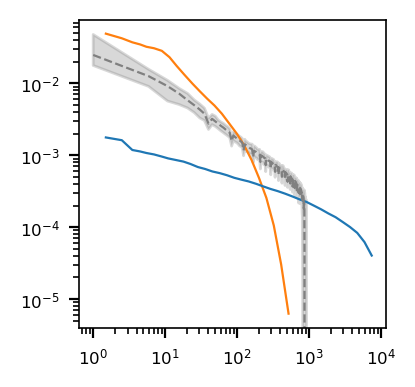

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data0, color='C1', ax=ax)
powerlaw.plot_pdf(data, color='C0', ax=ax)

#trunc_plaw.plot_pdf(color='C1', linestyle='-.', ax=ax)
# for freq_null in freq_svmis_nulls_list:

#     freq_null = np.array(sorted(freq_null, reverse=True))
#     rank_null = np.arange(1, len(freq_null) + 1)
#     data_null = np.repeat(rank_null, freq_null)

#     powerlaw.plot_pdf(data_null, color='grey', alpha=0.1, ax=ax)

ax.fill_between(xgrid[:-1], lower_envelope, upper_envelope, color='grey', alpha=0.3, label='95% envelope nulls')
ax.plot(xgrid[:-1], median_pdf, color='grey', linestyle='--', label='Median null')


ax.set_aspect("equal", adjustable='box')

In [128]:
data_fitted = powerlaw.Fit(data, discrete=True, xmin=5, xmax=5000)

In [129]:
data_fitted.distribution_compare("truncated_power_law", "lognormal")

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


(np.float64(51.07816164206781), np.float64(1.319785589873941e-05))

In [ ]:
data_fitted.distribution_compare("truncated_power_law", "lognormal_positive")

In [130]:
data_fitted.distribution_compare("truncated_power_law", "exponential")

/home/user/miniconda3/envs/statistical-filters-hoi/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution exponential; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


(np.float64(1229.8645874539152), np.float64(8.744345617469576e-119))

In [131]:
data_fitted.truncated_power_law.alpha

np.float64(0.2939294232119569)

In [132]:
data_fitted.truncated_power_law.xmax

5000.0

In [133]:
ttt = data_fitted.truncated_power_law

In [136]:
ttt.parameter_names

['alpha', 'Lambda']

In [137]:
ttt.parameters

{'alpha': np.float64(0.2939294232119569),
 'Lambda': np.float64(0.00013811747488728796)}

In [1]:
0.00013811747488728796 ** -1

7240.213454641125

In [119]:
data_fitted.power_law.alpha

np.float64(1.0000000030427394)

In [120]:
xxx = data_fitted.power_law

In [121]:
for param in xxx.parameter_names:
    print(f"{param}: {getattr(xxx, param)}")

alpha: 1.0000000030427394


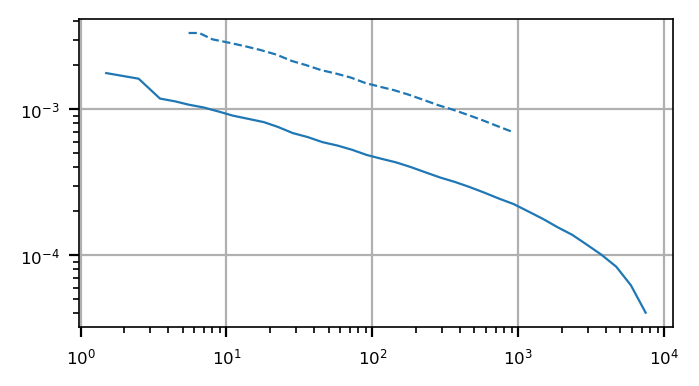

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

powerlaw.plot_pdf(data, ax=ax)

data_fitted.plot_pdf(color='C0', linestyle='--', ax=ax)

ax.grid()
ax.set_aspect("equal", adjustable="box")
fig.tight_layout()

In [65]:
from scipy import stats

<Axes: >

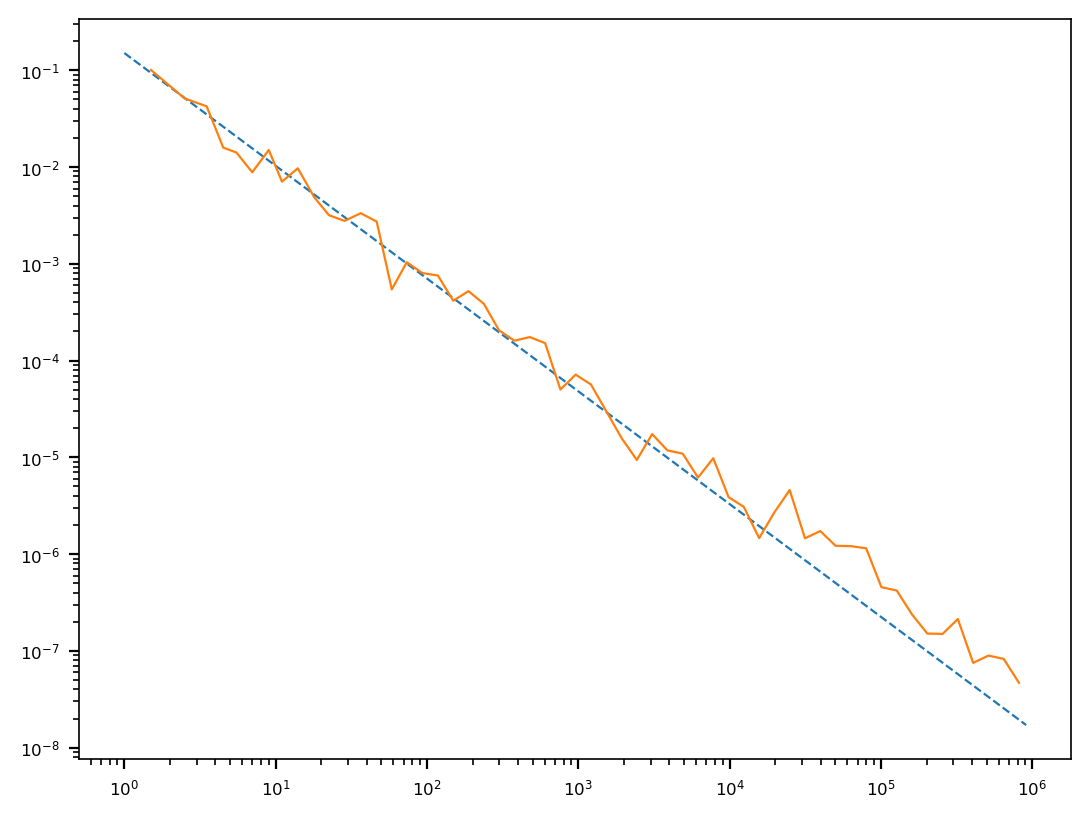

In [80]:
ddd = stats.zipf.rvs(1.05, size=1000)
ddd = ddd[ddd < 1_000_000]
data_fitted_zipf = powerlaw.Fit(ddd, xmin=1, discrete=True)

data_fitted_zipf.power_law.plot_pdf(linestyle='--')
powerlaw.plot_pdf(ddd)


In [ ]:
data_fitted_zipf.power_law.alpha

AttributeError: powerlaw

In [ ]:
6

### Zipf like analysis of ingredients

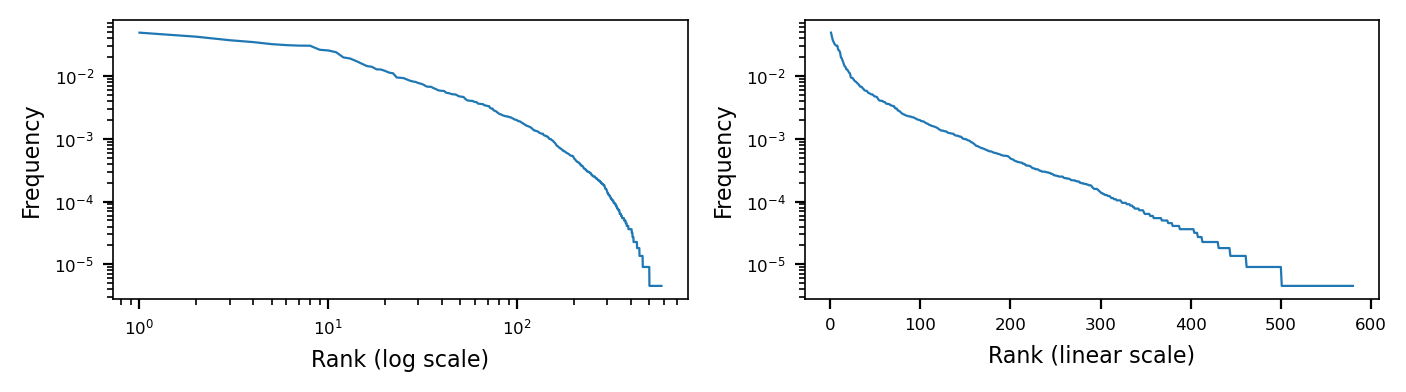

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

ys = np.array(sorted(list(H_cut.degree_sequence().values()), reverse=True))
xs = np.arange(1, len(ys) + 1)

ax = axs[0]
ax.plot(xs, ys / ys.sum(), marker='', linestyle='-')

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Rank (log scale)")

ax = axs[1]
ax.plot(xs, ys / ys.sum(), marker='', linestyle='-')

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Rank (linear scale)")

for ax in axs:
    ax.set_ylabel("Frequency")

fig.tight_layout()

### Zipf like analysis of validated sets

The idea is to count in how many recipes each SVMIS appears, and plot the distribution.

In [25]:
# count support of validated sets in recipes
all_recipes = set(H_cut.get_edges())

freq_svmis_df = []
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)
    group_ingredients = " - ".join([H_cut.get_node_metadata(n)["name"] for n in group])

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r).issuperset(group)}
    cuisines_ = [f for r in recipes_ for f in H_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

    line = {
        "group": group,
        "group_ingredients": group_ingredients,
        "size": len(group),
        "n_recipes": len(recipes_),
        "cuisine_list": cuisines_
    }

    freq_svmis_df.append(line)

freq_svmis_df = pd.DataFrame(freq_svmis_df)
freq_svmis_df.head()

  0%|          | 0/8297 [00:00<?, ?it/s]

,group,group_ingredients,size,n_recipes,cuisine_list
0,"{1, 39, 40, 15, 47, 17, 18, 58, 31}",chili pepper - rice - ghee - cardamom - ginger...,9,2,"[indian, indian]"
1,"{2, 7, 10, 11, 44, 13, 23, 56, 26}",sunflower - mustard oil - asafoetida - cayenne...,9,2,"[indian, indian]"
2,"{4, 8, 40, 10, 11, 15, 17, 18, 51}",cumin - nigella seed - ghee - asafoetida - cay...,9,2,"[indian, indian]"
3,"{1, 2, 3, 7, 10, 12, 13, 23, 26}",chili pepper - sunflower - buttermilk - mustar...,9,2,"[indian, indian]"
4,"{1, 2, 3, 4, 40, 10, 45, 26, 29}",chili pepper - sunflower - buttermilk - cumin ...,9,2,"[indian, indian]"


In [35]:
# save it
df_ = freq_svmis_df[["group_ingredients", "size", "n_recipes"]].sort_values("n_recipes", ascending=False).reset_index(drop=True).reset_index(names=["rank"])
df_["rank"] += 1

df_.to_csv("freq_rank_svmis_all.csv", index=False)

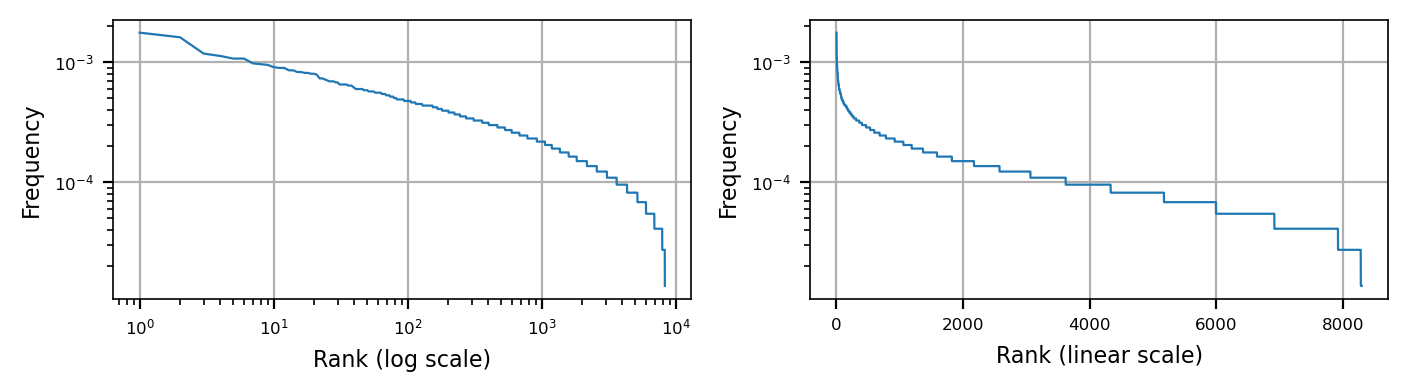

In [36]:
ys = np.array(sorted(freq_svmis_df.n_recipes.values, reverse=True))
xs = np.arange(1, len(ys) + 1)

fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

ax = axs[0]
ax.plot(xs, ys / ys.sum(), marker='', linestyle='-')

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Rank (log scale)")

ax = axs[1]
ax.plot(xs, ys / ys.sum(), marker='', linestyle='-')

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Rank (linear scale)")

for ax in axs:
    ax.set_ylabel("Frequency")
    ax.grid()


fig.tight_layout()

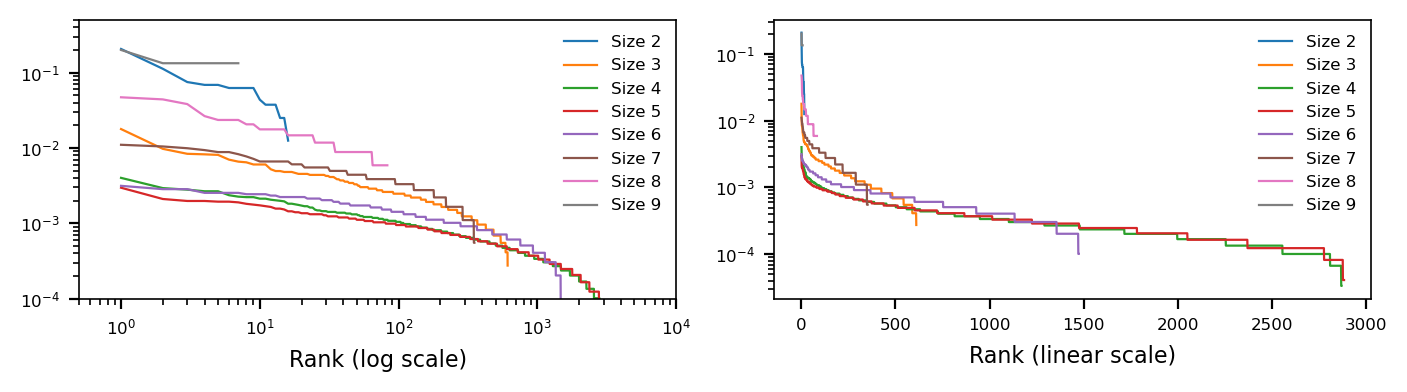

In [37]:
# split by size
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))


for size, rows in freq_svmis_df.groupby("size"):

    ys = np.array(sorted(rows.n_recipes.values, reverse=True))
    xs = np.arange(1, len(ys) + 1)

    axs[0].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=f"Size {size}")

    axs[1].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=f"Size {size}")

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].set_xlabel("Rank (log scale)")
axs[0].legend(frameon=False)

axs[1].set_yscale("log")
axs[1].set_xlabel("Rank (linear scale)")
axs[1].legend(frameon=False)

axs[0].set_xlim(0.5, 1e4)
axs[0].set_ylim(1e-4, 0.5)

fig.tight_layout()

In [38]:
all_cuisines_list

['indian',
 'african',
 'chinese',
 'thai',
 'south_east_asia',
 'middle_east',
 'korean',
 'japanese',
 'australasian',
 'mexican',
 'caribbean',
 'south_american',
 'central_european',
 'greek',
 'french',
 'misc_portuguese',
 'italian',
 'british_isles',
 'scandinavian',
 'east_european',
 'spanish',
 'american',
 'canadian']

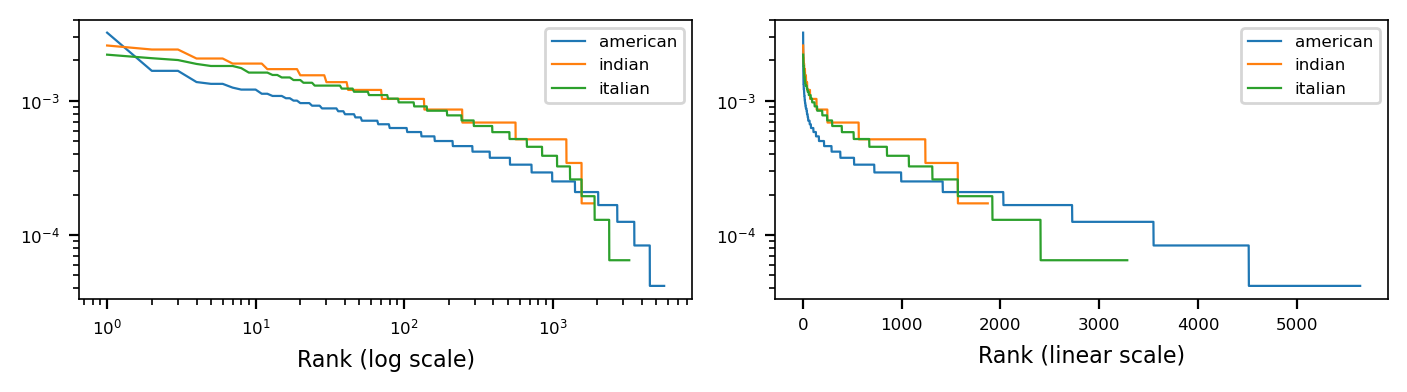

In [39]:
# do the same for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

for cuisine, rows in freq_svmis_df[["group", "cuisine_list"]].explode("cuisine_list").groupby("cuisine_list"):

    if cuisine not in ["italian", "american", "indian"]:
        continue

    ys = np.array(sorted(rows.group.value_counts().values, reverse=True))
    xs = np.arange(1, len(ys) + 1)

    axs[0].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=cuisine)
    axs[1].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=cuisine)

axs[0].legend()
axs[1].legend()

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].set_xlabel("Rank (log scale)")

axs[1].set_yscale("log")
axs[1].set_xlabel("Rank (linear scale)")

fig.tight_layout()

In [50]:
# save the one by cuisine
df_ = freq_svmis_df.explode("cuisine_list").groupby(["cuisine_list", "group_ingredients"])\
                        .agg(
                            size=("size", "first"),
                            n_recipes=("n_recipes", "size")
                        )\
                        .reset_index()\
                        .sort_values(["cuisine_list", "n_recipes"], ascending=[True, False])

df_.loc[:, "rank"] = df_.groupby("cuisine_list")["n_recipes"].rank(method="first", ascending=False).astype(int)

df_.rename(columns={"cuisine_list": "cuisine"}, inplace=True)

df_.to_csv("freq_rank_svmis_by_cuisine.csv", index=False)

### Well, this could just come from the selection process of validated sets

The idea is that filtering validated sets could kill the long exponential tail and make the distribution look power law. Indeed, this process is keeping frequent sets (or unfrequent but unusual) and removing the ones that do not occur often enough.

Let us assume that this concern is true. Then, I would observe this power-law behavior even if I completely randomize the ingredient-recipe network. Let's have a try.

In [250]:
def randomize_bip_conf_model(recipes_df, seed=None):
    """ Ensuring node labels are the same
    """
    import networkx as nx

    # make the 
    G = nx.Graph()
    #G = nx.from_pandas_edgelist(recipes_df, source="id", target="ingredient", create_using=nx.Graph)

    ing_nodes = recipes_df["ingredient"].unique().tolist()
    rec_nodes = recipes_df["id"].unique().tolist()

    G.add_nodes_from(ing_nodes, bipartite=0)
    G.add_nodes_from(rec_nodes, bipartite=1)

    G.add_edges_from(recipes_df[["id", "ingredient"]].values.tolist())

    ing_deg_seq = [G.degree(ing) for ing in ing_nodes]
    rec_deg_seq = [G.degree(rec) for rec in rec_nodes]

    # # create empty graph with your original labels
    # G_rand = nx.Graph()
    # G_rand.add_nodes_from(rec_nodes, bipartite=0)
    # G_rand.add_nodes_from(ing_nodes, bipartite=1)

    # build configuration model with explicit node lists
    G_tmp = nx.bipartite.configuration_model(
        rec_deg_seq,
        ing_deg_seq,
        create_using=nx.Graph(), 
        seed=seed
    )

    # mapping from autogenerated nodes -> original labels
    left_map  = dict(zip(range(len(rec_nodes)), rec_nodes))
    right_map = dict(zip(range(len(rec_nodes), len(rec_nodes)+len(ing_nodes)), ing_nodes))

    mapping = {**left_map, **right_map}

    # relabel nodes
    G_tmp = nx.relabel_nodes(G_tmp, mapping)

    # return to dataframe
    recipes_rand_df = []
    for rec_id in rec_nodes:
        for ing in G_tmp.neighbors(rec_id):
        #for ing in G.neighbors(rec_id):
            recipes_rand_df.append([rec_id, ing])

    recipes_rand_df = pd.DataFrame(recipes_rand_df, columns=["id", "ingredient"])
    recipes_rand_df = recipes_rand_df.merge(recipes_df[["id", "cuisine"]].drop_duplicates(), on="id", how="left")

    return recipes_rand_df


def load_recipies_shuff(seed=None):

    if seed is None:
        seed = 42

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")
    recipes_df = recipes_df[~recipes_df.cuisine.isin(CUISINES_EXCLUDE)]

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()

    # shuffle in like a bipartite configuration model for each cuisine
    recipes_shuff_df = []
    for iii, cuisine in enumerate(all_cuisines_list):
        df_ = recipes_df[recipes_df["cuisine"] == cuisine]
        df_shuff = randomize_bip_conf_model(df_, seed=seed + iii * 123)
        recipes_shuff_df.append(df_shuff)

    recipes_df = pd.concat(recipes_shuff_df).reset_index(drop=True)
        
    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        if cuisine in CUISINES_EXCLUDE:
            continue

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]
            #category = row["category"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                #H.add_node(node_id, metadata={"name": ingredient, "category": category})
                H.add_node(node_id, metadata={"name": ingredient})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            #edge_meta["title"] += f" - {r_meta['title']}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list

In [251]:
H_shuff, _, _ = load_recipies_shuff(seed=42)
H_shuff.num_nodes(), H_shuff.num_edges()

(603, 44836)

In [252]:
# for comparison..
H.num_nodes(), H.num_edges()

(604, 43751)

In [253]:
# remove hyperedges of size > 10
H_shuff_cut = H_shuff.copy()

for size in range(11, H_shuff_cut.max_size() + 1):
    for edge in H_shuff_cut.get_edges(size=size):
        H_shuff_cut.remove_edge(edge)

# remove isolated nodes
for node in H_shuff_cut.isolated_nodes():
    H_shuff_cut.remove_node(node)

print("Number of nodes after cutting: ", H_shuff_cut.num_nodes())
print("Number of hyperedges after cutting: ", H_shuff_cut.num_edges())
print("Number of recipes after cutting: ", sum(H_shuff_cut.get_weights()))

Number of nodes after cutting:  571
Number of hyperedges after cutting:  36553
Number of recipes after cutting:  36553


In [254]:
# run SVMIS extraction
svmis_shuff_df = get_svmis(H_shuff_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
svmis_shuff_df = pd.concat(svmis_shuff_df).reset_index(drop=True)
svmis_shuff_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

,group,pvalue,fdr
0,"(4, 5, 10, 21, 33, 37, 62, 66, 67, 68)",2.978356e-11,False
1,"(6, 11, 14, 21, 26, 60, 62, 69, 70, 71)",1.287935e-14,False
2,"(1, 7, 19, 21, 28, 43, 78, 95, 96, 97)",8.664355e-11,False
3,"(4, 13, 14, 16, 18, 26, 33, 46, 52, 99)",1.746029e-10,False
4,"(0, 1, 7, 8, 33, 37, 46, 58, 97, 117)",9.682602e-13,False


In [255]:
# count support of validated sets in recipes
all_recipes_shuff = set(H_shuff_cut.get_edges())

freq_svmis_shuff_df = []
for _, row in tqdm(svmis_shuff_df.query("fdr == True").iterrows(), total=svmis_shuff_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes_shuff if set(r).issuperset(group)}
    cuisines_ = [f for r in recipes_ for f in H_shuff_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

    line = {
        "group": group,
        "size": len(group),
        "n_recipes": len(recipes_),
        "cuisine_list": cuisines_
    }

    freq_svmis_shuff_df.append(line)

freq_svmis_shuff_df = pd.DataFrame(freq_svmis_shuff_df)
freq_svmis_shuff_df.head()

  0%|          | 0/848 [00:00<?, ?it/s]

,group,size,n_recipes,cuisine_list
0,"{7, 9, 11, 16, 26}",5,5,"[indian, indian, indian, indian, indian]"
1,"{7, 9, 14, 15, 26}",5,4,"[indian, indian, indian, indian]"
2,"{193, 16, 147, 119, 92}",5,3,"[thai, thai, thai]"
3,"{8, 9, 10, 7}",4,4,"[indian, indian, indian, indian]"
4,"{9, 11, 21, 33}",4,7,"[indian, indian, indian, indian, indian, india..."


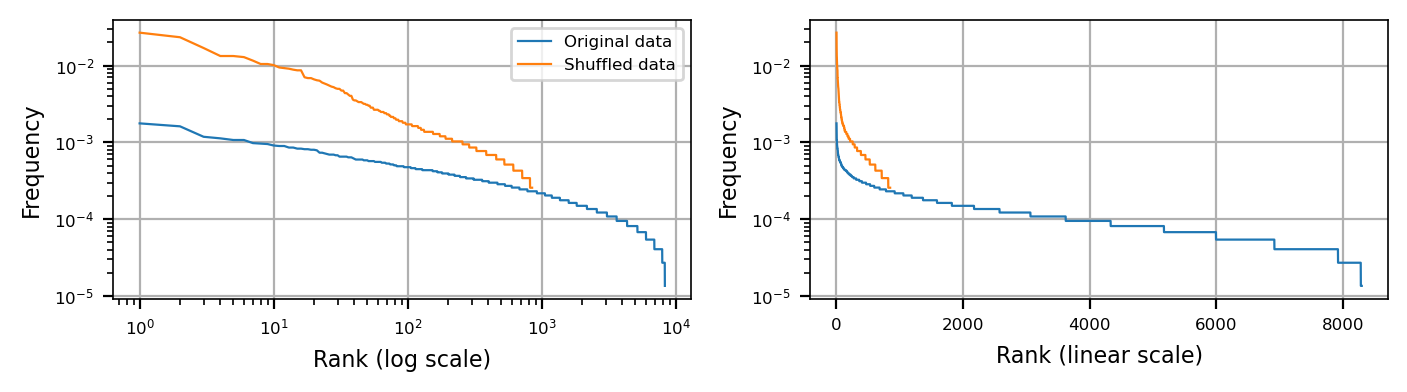

In [259]:
ys_shuff = np.array(sorted(freq_svmis_shuff_df.n_recipes.values, reverse=True))
xs_shuff = np.arange(1, len(ys_shuff) + 1)

ys_true = np.array(sorted(freq_svmis_df.n_recipes.values, reverse=True))
xs_true = np.arange(1, len(ys_true) + 1)

fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

ax = axs[0]
ax.plot(xs_true, ys_true / ys_true.sum(), marker='', linestyle='-', color="C0", label="Original data")
ax.plot(xs_shuff, ys_shuff / ys_shuff.sum(), marker='', linestyle='-', color="C1", label="Shuffled data")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Rank (log scale)")

ax.legend()

ax = axs[1]
ax.plot(xs_true, ys_true / ys_true.sum(), marker='', linestyle='-', color="C0", label="Original data")
ax.plot(xs_shuff, ys_shuff / ys_shuff.sum(), marker='', linestyle='-', color="C1", label="Shuffled data")

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Rank (linear scale)")

for ax in axs:
    ax.set_ylabel("Frequency")

    ax.grid()


fig.tight_layout()

##### Do the whole thing a few times

In [260]:
def get_freq_rank_plot_shuff(seed=None):

    H_shuff, _, _ = load_recipies_shuff(seed=seed)

    # remove hyperedges of size > 10
    H_shuff_cut = H_shuff.copy()

    for size in range(11, H_shuff_cut.max_size() + 1):
        for edge in H_shuff_cut.get_edges(size=size):
            H_shuff_cut.remove_edge(edge)

    # remove isolated nodes
    for node in H_shuff_cut.isolated_nodes():
        H_shuff_cut.remove_node(node)

    print("Number of nodes after cutting: ", H_shuff_cut.num_nodes())
    print("Number of hyperedges after cutting: ", H_shuff_cut.num_edges())
    print("Number of recipes after cutting: ", sum(H_shuff_cut.get_weights()))

    # run SVMIS extraction
    svmis_shuff_df = get_svmis(H_shuff_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_shuff_df = pd.concat(svmis_shuff_df).reset_index(drop=True)

    # count support of validated sets in recipes
    all_recipes_shuff = set(H_shuff_cut.get_edges())

    freq_svmis_shuff_df = []
    for _, row in tqdm(svmis_shuff_df.query("fdr == True").iterrows(), total=svmis_shuff_df.fdr.sum()):
        
        # the the validated set
        group = row["group"]
        group = set(group)

        # get all recipes that contain this group and the set of cuisines those recipes belong to
        recipes_ = {r for r in all_recipes_shuff if set(r).issuperset(group)}
        cuisines_ = [f for r in recipes_ for f in H_shuff_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

        line = {
            "group": group,
            "size": len(group),
            "n_recipes": len(recipes_),
            "cuisine_list": cuisines_
        }

        freq_svmis_shuff_df.append(line)

    freq_svmis_shuff_df = pd.DataFrame(freq_svmis_shuff_df)

    return freq_svmis_shuff_df

In [261]:
freq_svmis_shuff_df_list = []
for seed in [42, 123, 987, 1, 911]:
    print("Seed: ", seed)
    freq_svmis_shuff_df = get_freq_rank_plot_shuff(seed=seed)
    freq_svmis_shuff_df_list.append(freq_svmis_shuff_df)

    print()

Seed:  42
Number of nodes after cutting:  571
Number of hyperedges after cutting:  36553
Number of recipes after cutting:  36553


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]


Seed:  123
Number of nodes after cutting:  574
Number of hyperedges after cutting:  36569
Number of recipes after cutting:  36569


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/847 [00:00<?, ?it/s]


Seed:  987
Number of nodes after cutting:  578
Number of hyperedges after cutting:  36556
Number of recipes after cutting:  36556


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]


Seed:  1
Number of nodes after cutting:  574
Number of hyperedges after cutting:  36601
Number of recipes after cutting:  36601


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]


Seed:  911
Number of nodes after cutting:  572
Number of hyperedges after cutting:  36626
Number of recipes after cutting:  36626


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

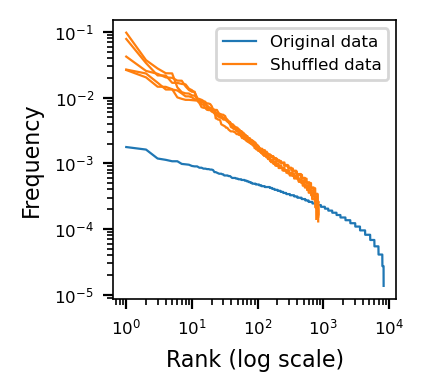

In [266]:
ys_true = np.array(sorted(freq_svmis_df.n_recipes.values, reverse=True))
xs_true = np.arange(1, len(ys_true) + 1)

fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/2, h_inc))

ax.plot(xs_true, ys_true / ys_true.sum(), marker='', linestyle='-', color="C0", label="Original data")

for freq_svmis_shuff_df in freq_svmis_shuff_df_list:
    ys_shuff = np.array(sorted(freq_svmis_shuff_df.n_recipes.values, reverse=True))
    xs_shuff = np.arange(1, len(ys_shuff) + 1)
    ax.plot(xs_shuff, ys_shuff / ys_shuff.sum(), marker='', linestyle='-', color="C1", label="Shuffled data")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Rank (log scale)")
ax.set_ylabel("Frequency")

ax.legend()
hand, labs = ax.get_legend_handles_labels()
ax.legend(handles=hand[:2], labels=labs[:2])

ax.set_aspect("equal", adjustable="box")
fig.tight_layout()

### Cluster cuisines based on validated sets

In [70]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

In [12]:
# check if validated sets are proper recipies
all_recipes = set(H_cut.get_edges())

validated_as_proper_recipes = []
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r) == group}

    if len(recipes_) > 0:
        line = {
            "group": group,
            "size": len(group),
            "is_proper_recipe": True,
            "num_recipes": len(recipes_),
            "recipe_ids": [H_cut.get_edge_metadata(r)["recipe_id"] for r in recipes_]
        }
    else:
        line = {
            "group": group,
            "size": len(group),
            "is_proper_recipe": False,
            "num_recipes": 0,
            "recipe_ids": []
        }
    validated_as_proper_recipes.append(line)

validated_as_proper_recipes_df = pd.DataFrame(validated_as_proper_recipes)
validated_as_proper_recipes_df.head()

  0%|          | 0/8297 [00:00<?, ?it/s]

,group,size,is_proper_recipe,num_recipes,recipe_ids
0,"{1, 39, 40, 15, 47, 17, 18, 58, 31}",9,True,1,[1660]
1,"{2, 7, 10, 11, 44, 13, 23, 56, 26}",9,False,0,[]
2,"{4, 8, 40, 10, 11, 15, 17, 18, 51}",9,False,0,[]
3,"{1, 2, 3, 7, 10, 12, 13, 23, 26}",9,False,0,[]
4,"{1, 2, 3, 4, 40, 10, 45, 26, 29}",9,True,1,[1429]


In [17]:
svmis_df.query("fdr == True").shape[0]

8297

In [18]:
svmis_df.query("fdr == True").groupby("size").size()

size
2      16
3     611
4    2870
5    2884
6    1474
7     352
8      83
9       7
dtype: int64

In [15]:
validated_as_proper_recipes_df.groupby("size").is_proper_recipe.mean()

size
2    0.000000
3    0.052373
4    0.042857
5    0.049584
6    0.080054
7    0.159091
8    0.349398
9    0.428571
Name: is_proper_recipe, dtype: float64

In [16]:
validated_as_proper_recipes_df.is_proper_recipe.mean()

np.float64(0.06074484753525371)

In [51]:
# build one hypergraph for each cuisine composed of validated sets
# for each validated set, get all cuisines with at least one recipe containing the set
all_recipes = set(H_cut.get_edges())

H_svmis_all_cuisines = {}
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r).issuperset(group)}
    cuisines_ = set([c for r in recipes_ for c in H_cut.get_edge_metadata(r)["cuisine"].split(" - ")])

    for c in cuisines_:
        if c not in H_svmis_all_cuisines:
            H_svmis_all_cuisines[c] = hgx.Hypergraph()

        # add edge
        if not H_svmis_all_cuisines[c].check_edge(group):
            H_svmis_all_cuisines[c].add_edge(group)



  0%|          | 0/8297 [00:00<?, ?it/s]

In [134]:
# for each pair of cuisines, compute jaccard distance based on validated sets
cousine_similarities_svmis_all = np.ones((len(H_svmis_all_cuisines), len(H_svmis_all_cuisines)))
cousine_similarities_svmis_all_df = []

all_cuisines = list(H_svmis_all_cuisines.keys())
for i, cuisine_i in enumerate(all_cuisines):
    for j, cuisine_j in enumerate(all_cuisines):
        if j <= i:
            continue
        
        H_i = H_svmis_all_cuisines[cuisine_i]
        edges_i = set([frozenset(e) for e in H_i.get_edges()])

        H_j = H_svmis_all_cuisines[cuisine_j]
        edges_j = set([frozenset(e) for e in H_j.get_edges()])

        # compute jaccard between edges
        inters = edges_i.intersection(edges_j)
        union = edges_i.union(edges_j)
        jacc = len(inters) / len(union)

        cousine_similarities_svmis_all[i, j] = jacc
        cousine_similarities_svmis_all[j, i] = jacc
        line = {
            "cuisine_i": cuisine_i,
            "cuisine_j": cuisine_j,
            "intersection_size": len(inters),
            "union_size": len(union),
            "jaccard": jacc,
            "num_nodes_i": H_i.num_nodes(),
            "num_nodes_j": H_j.num_nodes(),
            "num_edges_i": H_i.num_edges(),
            "num_edges_j": H_j.num_edges(),
        }
        cousine_similarities_svmis_all_df.append(line)

cousine_distances_svmis_all = 1 - cousine_similarities_svmis_all

cousine_similarities_svmis_all_df = pd.DataFrame(cousine_similarities_svmis_all_df)
cousine_similarities_svmis_all_df.head()

,cuisine_i,cuisine_j,intersection_size,union_size,jaccard,num_nodes_i,num_nodes_j,num_edges_i,num_edges_j
0,indian,british_isles,66,3031,0.021775,186,164,1871,1226
1,indian,chinese,72,2387,0.030163,186,129,1871,588
2,indian,american,389,7125,0.054596,186,290,1871,5643
3,indian,east_european,48,2412,0.019900,186,126,1871,589
4,indian,misc_portuguese,20,2040,0.009804,186,63,1871,189


In [177]:
# perform hierarchical clustering with complete linkage
condensed_svmis_all = squareform(cousine_distances_svmis_all)
Z_svmis_all = linkage(condensed_svmis_all, method="complete", ) 

# use silhouette method to determine the optimal threshold to cut the dendrogram
cuts = np.linspace(0.6, 1., 20)
scores = []

for t in cuts:
    labels = fcluster(Z_svmis_all, t=t, criterion="distance")
    if len(np.unique(labels)) > 1:
        score = silhouette_score(
            cousine_distances_svmis_all,
            labels,
            metric="precomputed"
        )
        scores.append(score)
    else:
        scores.append(np.nan)

best_t = cuts[np.nanargmax(scores)]
print(best_t)

0.8736842105263158


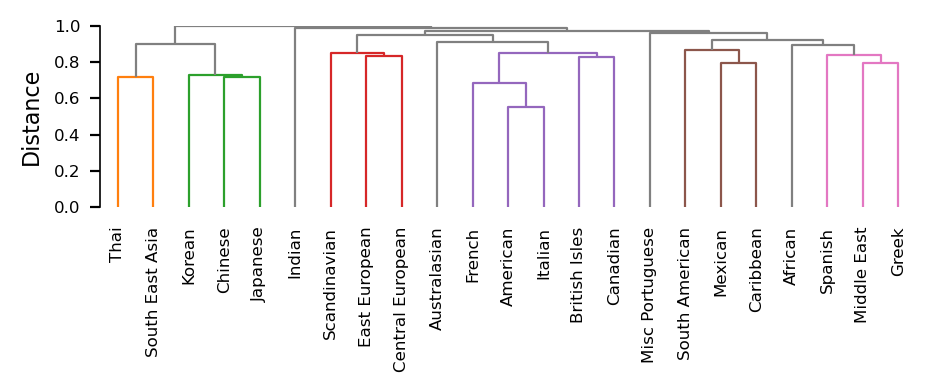

In [178]:
# Plot dendrogram
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3*2, h_inc))

dendrogram(Z_svmis_all, labels=all_cuisines, color_threshold=best_t, above_threshold_color="grey", orientation="top", ax=ax)
ax.set_ylabel("Distance")
ax.set_ylim(top=1.0)

ax.tick_params(axis='x', labelsize=6, rotation=90)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(ax.get_xticks())
xticklabels = [t.get_text().replace("_", " ").title() for t in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)


fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_Cuisine_Dendrogram.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### With Helcio hgraph similarity measure

In [75]:
from hgraph_similarity import NMIcross

In [82]:
# for each pair of cuisines, compute jaccard distance based on validated sets
cousine_similarities_svmis_all_nmi = np.ones((len(H_svmis_all_cuisines), len(H_svmis_all_cuisines)))
cousine_similarities_svmis_all_nmi_df = []

all_cuisines = list(H_svmis_all_cuisines.keys())
for i, cuisine_i in enumerate(all_cuisines):
    for j, cuisine_j in enumerate(all_cuisines):
        if j <= i:
            continue
        
        H_i = H_svmis_all_cuisines[cuisine_i]
        edges_i = [e for e in H_i.get_edges()]

        H_j = H_svmis_all_cuisines[cuisine_j]
        edges_j = [e for e in H_j.get_edges()]

        # compute jaccard between edges
        #inters = edges_i.intersection(edges_j)
        #union = edges_i.union(edges_j)
        #jacc = len(inters) / len(union)
        jacc = NMIcross(edges_i, edges_j)

        cousine_similarities_svmis_all_nmi[i, j] = jacc
        cousine_similarities_svmis_all_nmi[j, i] = jacc
        line = {
            "cuisine_i": cuisine_i,
            "cuisine_j": cuisine_j,
            "intersection_size": len(inters),
            "union_size": len(union),
            "jaccard": jacc,
            "num_nodes_i": H_i.num_nodes(),
            "num_nodes_j": H_j.num_nodes(),
            "num_edges_i": H_i.num_edges(),
            "num_edges_j": H_j.num_edges(),
        }
        cousine_similarities_svmis_all_nmi_df.append(line)

cousine_distances_svmis_all_nmi = 1 - cousine_similarities_svmis_all_nmi

cousine_similarities_svmis_all_nmi_df = pd.DataFrame(cousine_similarities_svmis_all_nmi_df)
cousine_similarities_svmis_all_nmi_df.head()

,cuisine_i,cuisine_j,intersection_size,union_size,jaccard,num_nodes_i,num_nodes_j,num_edges_i,num_edges_j
0,indian,british_isles,21,643,0.031579,186,164,1871,1226
1,indian,chinese,21,643,0.075548,186,129,1871,588
2,indian,american,21,643,0.125799,186,290,1871,5643
3,indian,east_european,21,643,0.051032,186,126,1871,589
4,indian,misc_portuguese,21,643,0.061062,186,63,1871,189


In [83]:
cousine_similarities_svmis_all_nmi_df.jaccard.describe()

count    253.000000
mean       0.208808
std        0.184875
min        0.001855
25%        0.085027
50%        0.143955
75%        0.255941
max        0.814421
Name: jaccard, dtype: float64

In [179]:
# perform hierarchical clustering with complete linkage
condensed_svmis_all_nmi = squareform(cousine_distances_svmis_all_nmi)
Z_svmis_all_nmi = linkage(condensed_svmis_all_nmi, method="complete", ) 

# use silhouette method to determine the optimal threshold to cut the dendrogram
cuts = np.linspace(0.2, 1., 50)
scores = []

for t in cuts:
    labels = fcluster(Z_svmis_all_nmi, t=t, criterion="distance")
    if len(np.unique(labels)) > 1:
        score = silhouette_score(
            cousine_distances_svmis_all_nmi,
            labels,
            metric="precomputed"
        )
        scores.append(score)
    else:
        scores.append(np.nan)

best_t = cuts[np.nanargmax(scores)]
print(best_t)

0.9673469387755103


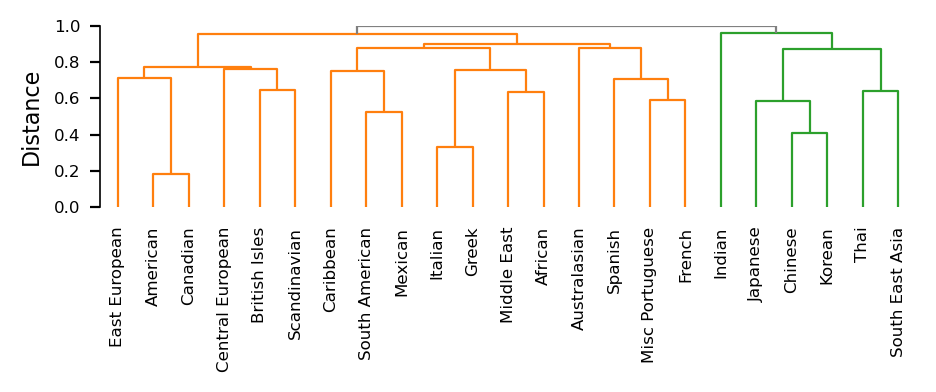

In [180]:
# Plot dendrogram
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3*2, h_inc))

dendrogram(Z_svmis_all_nmi, labels=all_cuisines, color_threshold=best_t, above_threshold_color="grey", orientation="top", ax=ax)
ax.set_ylabel("Distance")
ax.set_ylim(top=1.0)

ax.tick_params(axis='x', labelsize=6, rotation=90)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(ax.get_xticks())
xticklabels = [t.get_text().replace("_", " ").title() for t in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)


fig.tight_layout()

# fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_Cuisine_Dendrogram.pdf")
# if not os.path.exists(fig_file_name):
#     fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### As comparison, cluster on validated sets ingredients only

In [102]:
# for each pair of cuisines, compute jaccard distance based on validated sets
cousine_similarities_svmis_ingredients = np.ones((len(H_svmis_all_cuisines), len(H_svmis_all_cuisines)))
cousine_similarities_svmis_ingredients_df = []

all_cuisines = list(H_svmis_all_cuisines.keys())
for i, cuisine_i in enumerate(all_cuisines):
    for j, cuisine_j in enumerate(all_cuisines):
        if j <= i:
            continue
        
        H_i = H_svmis_all_cuisines[cuisine_i]
        #edges_i = set([frozenset(e) for e in H_i.get_edges()])
        nodes_i = set(H_i.get_nodes())

        H_j = H_svmis_all_cuisines[cuisine_j]
        #edges_j = set([frozenset(e) for e in H_j.get_edges()])
        nodes_j = set(H_j.get_nodes())

        # compute jaccard between edges
        # inters = edges_i.intersection(edges_j)
        # union = edges_i.union(edges_j)
        inters = nodes_i.intersection(nodes_j)
        union = nodes_i.union(nodes_j)
        jacc = len(inters) / len(union)

        cousine_similarities_svmis_ingredients[i, j] = jacc
        cousine_similarities_svmis_ingredients[j, i] = jacc
        line = {
            "cuisine_i": cuisine_i,
            "cuisine_j": cuisine_j,
            "intersection_size": len(inters),
            "union_size": len(union),
            "jaccard": jacc,
            "num_nodes_i": H_i.num_nodes(),
            "num_nodes_j": H_j.num_nodes(),
            "num_edges_i": H_i.num_edges(),
            "num_edges_j": H_j.num_edges(),
        }
        cousine_similarities_svmis_ingredients_df.append(line)

cousine_distances_svmis_ingredients = 1 - cousine_similarities_svmis_ingredients

cousine_similarities_svmis_ingredients_df = pd.DataFrame(cousine_similarities_svmis_ingredients_df)
cousine_similarities_svmis_ingredients_df.head()

,cuisine_i,cuisine_j,intersection_size,union_size,jaccard,num_nodes_i,num_nodes_j,num_edges_i,num_edges_j
0,indian,british_isles,110,240,0.458333,186,164,1871,1226
1,indian,chinese,91,224,0.406250,186,129,1871,588
2,indian,american,154,322,0.478261,186,290,1871,5643
3,indian,east_european,92,220,0.418182,186,126,1871,589
4,indian,misc_portuguese,53,196,0.270408,186,63,1871,189


In [182]:
# perform hierarchical clustering with complete linkage
condensed_svmis_ingredients = squareform(cousine_distances_svmis_ingredients)
Z_svmis_ingredients = linkage(condensed_svmis_ingredients, method="complete", ) 

# use silhouette method to determine the optimal threshold to cut the dendrogram
cuts = np.linspace(0.3, 1., 50)
scores = []

for t in cuts:
    labels = fcluster(Z_svmis_ingredients, t=t, criterion="distance")
    if len(np.unique(labels)) > 1:
        score = silhouette_score(
            cousine_distances_svmis_ingredients,
            labels,
            metric="precomputed"
        )
        scores.append(score)
    else:
        scores.append(np.nan)

best_t = cuts[np.nanargmax(scores)]
print(best_t)

0.5571428571428572


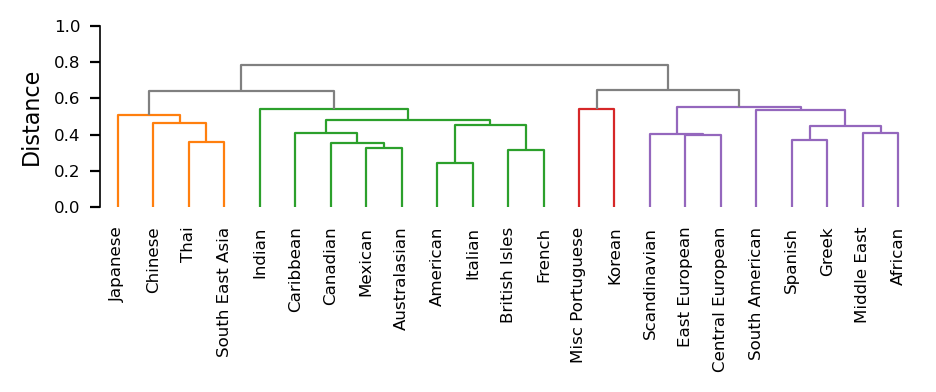

In [183]:
# Plot dendrogram
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3*2, h_inc))

dendrogram(Z_svmis_ingredients, labels=all_cuisines, color_threshold=best_t, above_threshold_color="grey", orientation="top", ax=ax)
ax.set_ylabel("Distance")
ax.set_ylim(top=1.0)

ax.tick_params(axis='x', labelsize=6, rotation=90)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(ax.get_xticks())
xticklabels = [t.get_text().replace("_", " ").title() for t in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)


fig.tight_layout()

# fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_Cuisine_Dendrogram.pdf")
# if not os.path.exists(fig_file_name):
#     fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### As a comparison, cluster on all ingredients

In [108]:
H_cuisines = {}
for cuisine in all_cuisines_list:
    H_cuisines[cuisine] = filter_by_cuisine(H_cut, cuisine)

In [186]:
# for each pair of cuisines, compute jaccard distance based on validated sets
cousine_similarities_ingredients = np.ones((len(H_cuisines), len(H_cuisines)))
cousine_similarities_ingredients_df = []

all_cuisines = list(H_cuisines.keys())
for i, cuisine_i in enumerate(all_cuisines):
    for j, cuisine_j in enumerate(all_cuisines):
        if j <= i:
            continue
        
        H_i = H_cuisines[cuisine_i]
        #edges_i = set([frozenset(e) for e in H_i.get_edges()])
        nodes_i = set(H_i.get_nodes())

        H_j = H_cuisines[cuisine_j]
        #edges_j = set([frozenset(e) for e in H_j.get_edges()])
        nodes_j = set(H_j.get_nodes())

        # compute jaccard between edges
        #inters = edges_i.intersection(edges_j)
        #union = edges_i.union(edges_j)
        inters = nodes_i.intersection(nodes_j)
        union = nodes_i.union(nodes_j)
        jacc = len(inters) / len(union)

        cousine_similarities_ingredients[i, j] = jacc
        cousine_similarities_ingredients[j, i] = jacc
        line = {
            "cuisine_i": cuisine_i,
            "cuisine_j": cuisine_j,
            "intersection_size": len(inters),
            "union_size": len(union),
            "jaccard": jacc,
            "num_nodes_i": H_i.num_nodes(),
            "num_nodes_j": H_j.num_nodes(),
            "num_edges_i": H_i.num_edges(),
            "num_edges_j": H_j.num_edges(),
        }
        cousine_similarities_ingredients_df.append(line)

cousine_distances_ingredients = 1 - cousine_similarities_ingredients

cousine_similarities_ingredients_df = pd.DataFrame(cousine_similarities_ingredients_df)
cousine_similarities_ingredients_df.head()

,cuisine_i,cuisine_j,intersection_size,union_size,jaccard,num_nodes_i,num_nodes_j,num_edges_i,num_edges_j
0,indian,african,179,335,0.534328,303,211,2766,371
1,indian,chinese,181,346,0.523121,303,224,2766,572
2,indian,thai,161,333,0.483483,303,191,2766,359
3,indian,south_east_asia,162,338,0.479290,303,197,2766,339
4,indian,middle_east,200,348,0.574713,303,245,2766,714


In [187]:
# perform hierarchical clustering with complete linkage
condensed_ingredients = squareform(cousine_distances_ingredients)
Z_ingredients = linkage(condensed_ingredients, method="complete", ) 

# use silhouette method to determine the optimal threshold to cut the dendrogram
cuts = np.linspace(0.3, 1., 50)
scores = []

for t in cuts:
    labels = fcluster(Z_ingredients, t=t, criterion="distance")
    if len(np.unique(labels)) > 1:
        score = silhouette_score(
            cousine_distances_ingredients,
            labels,
            metric="precomputed"
        )
        scores.append(score)
    else:
        scores.append(np.nan)

best_t = cuts[np.nanargmax(scores)]
print(best_t)

0.5285714285714286


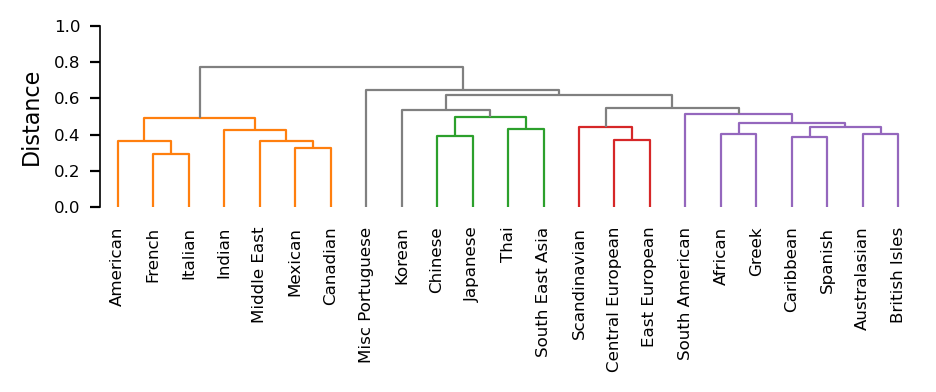

In [188]:
# Plot dendrogram
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3*2, h_inc))

dendrogram(Z_ingredients, labels=all_cuisines, color_threshold=best_t, above_threshold_color="grey", orientation="top", ax=ax)
ax.set_ylabel("Distance")
ax.set_ylim(top=1.0)

ax.tick_params(axis='x', labelsize=6, rotation=90)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(ax.get_xticks())
xticklabels = [t.get_text().replace("_", " ").title() for t in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)


fig.tight_layout()

# fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_Cuisine_Dendrogram.pdf")
# if not os.path.exists(fig_file_name):
#     fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### Zipf like analysis for each cuisine

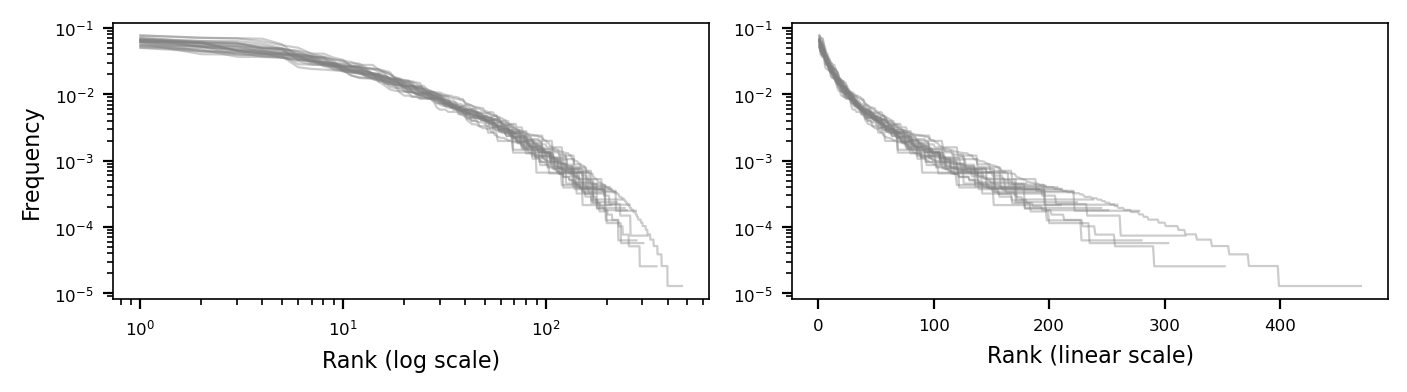

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

for cuisine, H_ in H_cuisines.items():

    ys = np.array(sorted(list(H_.degree_sequence().values()), reverse=True))
    xs = np.arange(1, len(ys) + 1)

    axs[0].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=cuisine.replace("misc_", "").replace("_", " ").title(), color="grey", alpha=0.4)
    axs[1].plot(xs, ys / ys.sum(), marker='', linestyle='-', label=cuisine.replace("misc_", "").replace("_", " ").title(), color="grey", alpha=0.4)


axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[0].set_xscale("log")

axs[0].set_xlabel("Rank (log scale)")
axs[1].set_xlabel("Rank (linear scale)")
axs[0].set_ylabel("Frequency")

fig.tight_layout()